### Loading the libraries

In [4]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Reading the data

In [5]:
train_df = pd.read_csv("train-flattened_v2.csv")
print(train_df.shape)

C:\Users\prash\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (2,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(903653, 55)


### Sneak Peek at the data

In [6]:
train_df.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,...,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,google + online,organic,NaN,google
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,Not Socially Engaged,1472822600,2,1472822600,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,True,(not provided),organic,NaN,google


### Getting the categorical and numerical columns

In [7]:
cols = train_df.columns
num_cols = train_df._get_numeric_data().columns
factor_cols = list(set(cols) - set(num_cols))

### Getting the count of missing values in the categorical values and plotting the same

Text(0.5,1,'Missing Values in Categorical Features')

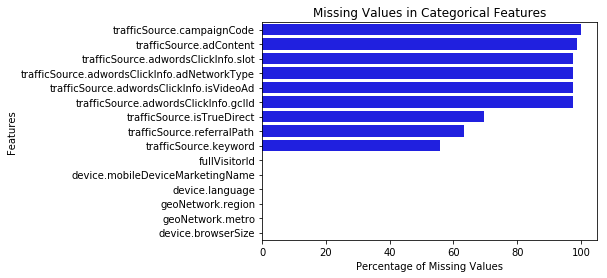

In [8]:
total_test = train_df[factor_cols].isnull().sum().sort_values(ascending=False)
percent = (train_df[factor_cols].isnull().sum()/train_df[factor_cols].isnull().count()).sort_values(ascending=False)*100
data_to_be_removed = pd.concat([total_test, percent], axis=1,join='outer', keys=['Missing Value Count', 'Percentage of Missing Values'])
data_to_be_removed.index.name ='Features'
#data_to_be_removed.head(20)
sns.barplot(y = data_to_be_removed.index[:15],x = data_to_be_removed['Percentage of Missing Values'][:15],color='blue').set_title("Missing Values in Categorical Features")

### Getting the count of missing values in the continuous variables and plotting it

Text(0.5,1,'Missing Values in Continuous Features')

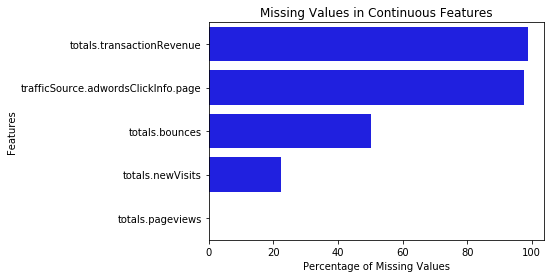

In [9]:
total_test1 = train_df[num_cols].isnull().sum().sort_values(ascending=False)
percent1 = (train_df[num_cols].isnull().sum()/train_df[num_cols].isnull().count()).sort_values(ascending=False)*100
data_to_be_removed1 = pd.concat([total_test1, percent1], axis=1,join='outer', keys=['Missing Value Count', 'Percentage of Missing Values'])
data_to_be_removed1.index.name ='Features'
#data_to_be_removed.head(20)
sns.barplot(y = data_to_be_removed1.index[:5],x = data_to_be_removed1['Percentage of Missing Values'][:5],color='blue').set_title("Missing Values in Continuous Features")

     Note : The feature 'totals.transactionRevenue' is the revenue generated in every session/log in of each user and if it's   missing, it means that no revenue was generated. So, rather than dropping the missing values, we should recode it to 0 in this case


### Now, let's check the number of levels in each categorical feature and we can drop features if they don't have missing values and have just 1 level

In [10]:
## Getting categorical columns with just 1 level
single_level_cols = [cols for cols in train_df[factor_cols].columns if train_df[cols].nunique(dropna=False)==1 ]

unique_vals_df = pd.DataFrame(columns=['Features'])
unique_vals_df['Features'] = single_level_cols

#tt = data_to_be_removed
#tt['Features'] = data_to_be_removed.index
#unique_vals_df = pd.merge(unique_vals_df,tt,on='Features',how='inner')
#unique_vals_df

     Note: It's surprising to see that all the categorical features with just 1 level do not have any missing value and we 
     can remove these features before proceeding with our analysis

### Removing Categorical features with just 1 level

In [11]:
train_df.drop(single_level_cols,axis=1,inplace=True)
print(train_df.shape)

(903653, 37)


### Before proceeding further with the exploratory analysis, we will generate our target variable of interest : Flag indicating if a customer is a revenue generating customer or not

In [353]:
group_cols = ['fullVisitorId']
counted = 'totals.transactionRevenue'
agg_name = 'totals.transactionRevenue_sum'
gp = train_df[group_cols+[counted]].groupby(group_cols)[counted].sum().reset_index().rename(columns={counted:agg_name})
#print(gp)
#train = train.merge(gp, on=group_cols, how='left')
gp['Revenue_Generating_Flag'] = np.where(gp['totals.transactionRevenue_sum']>0,1,0)
cols = ['fullVisitorId','Revenue_Generating_Flag']

train_df1 = pd.merge(train_df,gp[cols],on='fullVisitorId',how='inner')

In [354]:
train_df1['Revenue_Generating_Flag'].value_counts()

0    869638
1     34015
Name: Revenue_Generating_Flag, dtype: int64

In [355]:
train_df['date'] = pd.to_datetime(train_df['visitStartTime'], unit='s')
train_df['sess_date_dow'] = train_df['date'].dt.dayofweek
train_df['sess_date_hours'] = train_df['date'].dt.hour
train_df['sess_date_dom'] = train_df['date'].dt.day
train_df.sort_values(['fullVisitorId', 'date'], ascending=True, inplace=True)
train_df['next_session_1'] = (train_df['date'] - train_df[['fullVisitorId', 'date']].groupby('fullVisitorId')['date'].shift(1)).astype(np.int64) // 1e9 // 60 // 60
train_df['next_session_2'] = (train_df['date'] - train_df[['fullVisitorId', 'date']].groupby('fullVisitorId')['date'].shift(-1)).astype(np.int64) // 1e9 // 60 // 60

### Handling Categorical Variables

#### Device Broswer

In [356]:
train_df1['device.browser'].value_counts()

Chrome                                         620364
Safari                                         182245
Firefox                                         37069
Internet Explorer                               19375
Edge                                            10205
Android Webview                                  7865
Safari (in-app)                                  6850
Opera Mini                                       6139
Opera                                            5643
UC Browser                                       2427
YaBrowser                                        2096
Coc Coc                                           727
Amazon Silk                                       561
Android Browser                                   553
Mozilla Compatible Agent                          374
MRCHROME                                          263
Maxthon                                           246
BlackBerry                                        184
Nintendo Browser            

We can observe that the device browser has mutliple values but a lot of them are mobile browsers. We can combine these together as mobile browsers

In [357]:
def browser_wrangling(x):
    top_10_browsers = ['chrome','safari','firefox','internet explorer','edge','android webview','safari (in-app)','opera mini','opera','uc browser']
    #browsers = ['chrome','safari','firefox','internet explorer','edge','opera','coc coc','maxthon','iron']
    #mobile_browsers = ['android','samsung','mini','iphone','in-app','playstation','mozilla','chrome','blackberry','nokia','browser','amazon','lunascape','netscape','konqueror','puffin']
    
    if x in top_10_browsers:
        return x.lower()
    
    #elif x in mobile_browsers:
     #   return 'mobile browser'
    
    elif '(not set)' in x:
        return x
    
    else:
        return 'others'

In [358]:
train_df1['device.browser'] = train_df1['device.browser'].map(lambda x:browser_wrangling(str(x).lower())).astype('str')

In [359]:
train_df1['device.browser'].value_counts()

chrome               620364
safari               182245
firefox               37069
internet explorer     19375
edge                  10205
android webview        7865
safari (in-app)        6850
opera mini             6139
opera                  5643
others                 5463
uc browser             2427
(not set)                 8
Name: device.browser, dtype: int64

In [360]:
train_df1['trafficSource.adContent'].value_counts()

Google Merchandise Collection                  5122
Google Online Store                            1245
Display Ad created 3/11/14                      967
Full auto ad IMAGE ONLY                         822
Ad from 12/13/16                                610
Ad from 11/3/16                                 489
Display Ad created 3/11/15                      392
{KeyWord:Google Brand Items}                    251
{KeyWord:Google Merchandise}                    155
Ad from 11/7/16                                 123
First Full Auto Template Test Ad                 87
Google Merchandise                               87
20% discount                                     75
{KeyWord:Google Branded Gear}                    67
{KeyWord:Looking for Google Bags?}               65
Swag with Google Logos                           64
Display Ad created 11/17/14                      50
{KeyWord:Want Google Stickers?}                  42
JD_5a_v1                                         41
{KeyWord:Goo

In [361]:
def adcontents_wrangling(x):
    if  ('google' in x):
        return 'google'
    elif  ('placement' in x) | ('placememnt' in x):
        return 'placement'
    elif '(not set)' in x or 'nan' in x:
        return x
    elif 'ad' in x:
        return 'ad'
    else:
        return 'others'

In [362]:
train_df1['trafficSource.adContent'] = train_df1['trafficSource.adContent'].map(lambda x:adcontents_wrangling(str(x).lower())).astype('str')

In [363]:
train_df1['trafficSource.adContent'].value_counts()

nan       892707
google      7223
ad          3572
others       151
Name: trafficSource.adContent, dtype: int64

In [364]:
train_df1['trafficSource.source'].value_counts()

google                                               400788
youtube.com                                          212602
(direct)                                             143028
mall.googleplex.com                                   66416
Partners                                              16411
analytics.google.com                                  16172
dfa                                                    5686
google.com                                             4669
m.facebook.com                                         3365
baidu                                                  3356
sites.google.com                                       2983
facebook.com                                           2296
siliconvalley.about.com                                2097
reddit.com                                             2022
qiita.com                                              1813
quora.com                                              1546
bing                                    

In [365]:
def source_wrangling(x):
    if  ('google' in x):
        return 'google'
    elif  ('youtube' in x):
        return 'youtube'
    elif 'yahoo' in x:
        return 'yahoo'
    elif 'facebook' in x:
        return 'facebook'
    elif 'reddit' in x:
        return 'reddit'
    elif 'bing' in x:
        return 'bing'
    elif 'quora' in x:
        return 'quora'
    elif 'outlook' in x:
        return 'outlook'
    elif 'linkedin' in x:
        return 'linkedin'
    elif 'twitter' in x:
        return 'twitter'
    elif '(not set)' in x or 'nan' in x:
        return x
    else:
        return 'others'

In [366]:
train_df1['trafficSource.source'] = train_df1['trafficSource.source'].map(lambda x:source_wrangling(str(x).lower())).astype('str')

In [367]:
train_df1['trafficSource.source'].value_counts()

google       499205
youtube      212697
others       178156
facebook       6523
reddit         2106
yahoo          1702
quora          1546
bing           1536
outlook          85
(not set)        69
linkedin         23
twitter           5
Name: trafficSource.source, dtype: int64

In [368]:
train_df1['device.operatingSystem'].value_counts()

Windows          350072
Macintosh        253938
Android          123892
iOS              107665
Linux             35034
Chrome OS         26337
(not set)          4695
Windows Phone      1216
Samsung             280
BlackBerry          218
Nintendo Wii        100
Firefox OS           89
Xbox                 66
Nintendo WiiU        35
FreeBSD               9
Nokia                 2
OpenBSD               2
Nintendo 3DS          1
SunOS                 1
NTT DoCoMo            1
Name: device.operatingSystem, dtype: int64

In [369]:
def device_os_wrangling(x):
    top_10_device_os = ['windows','macintosh','andorid','ios', 'linux','chrome os','windows phone']
    #browsers = ['chrome','safari','firefox','internet explorer','edge','opera','coc coc','maxthon','iron']
    #mobile_browsers = ['android','samsung','mini','iphone','in-app','playstation','mozilla','chrome','blackberry','nokia','browser','amazon','lunascape','netscape','konqueror','puffin']
    
    if x in top_10_device_os:
        return x.lower()
    
    #elif x in mobile_browsers:
     #   return 'mobile browser'
    
    elif '(not set)' in x:
        return x
    
    else:
        return 'others'

In [370]:
train_df1['device.operatingSystem'] = train_df1['device.operatingSystem'].map(lambda x:device_os_wrangling(str(x).lower())).astype('str')

In [372]:
train_df1['geoNetwork.subContinent'].value_counts()

Northern America      390657
Southeast Asia         77800
Southern Asia          59321
Western Europe         59114
Northern Europe        58168
Eastern Asia           46919
Eastern Europe         45249
South America          41731
Western Asia           38443
Southern Europe        35780
Central America        15583
Australasia            14893
Northern Africa         7683
Western Africa          2573
Caribbean               2406
Southern Africa         2169
Eastern Africa          1927
(not set)               1468
Central Asia            1215
Middle Africa            393
Melanesia                 81
Micronesian Region        55
Polynesia                 25
Name: geoNetwork.subContinent, dtype: int64

In [373]:
train_df1['geoNetwork.networkDomain'].value_counts()

(not set)                 244881
unknown.unknown           146034
comcast.net                28743
rr.com                     14827
verizon.net                13637
ttnet.com.tr               13228
comcastbusiness.net         9985
hinet.net                   7919
virginm.net                 6414
3bb.co.th                   6046
prod-infinitum.com.mx       5960
cox.net                     5812
sbcglobal.net               5388
btcentralplus.com           5304
att.net                     5230
google.com                  5035
optonline.net               4972
totbb.net                   4895
vnpt.vn                     4508
asianet.co.th               4374
pldt.net                    4008
rima-tde.net                3963
amazonaws.com               3769
t-ipconnect.de              3656
telecomitalia.it            3571
qwest.net                   3534
airtelbroadband.in          3389
virtua.com.br               3318
bell.ca                     2904
ztomy.com                   2845
          

In [217]:
def process_device(data_df):
    print("process device ...")
    data_df['source.country'] = data_df['trafficSource.source'] + '_' + data_df['geoNetwork.country']
    data_df['campaign.medium'] = data_df['trafficSource.campaign'] + '_' + data_df['trafficSource.medium']
    data_df['browser.category'] = data_df['device.browser'] + '_' + data_df['device.deviceCategory']
    data_df['browser.os'] = data_df['device.browser'] + '_' + data_df['device.operatingSystem']
    return data_df
train_df1 = process_device(train_df1)

process device ...


In [218]:
def custom(data):
    print('custom..')
    data['device_deviceCategory_channelGrouping'] = data['device.deviceCategory'] + "_" + data['channelGrouping']
    data['channelGrouping_browser'] = data['device.browser'] + "_" + data['channelGrouping']
    data['channelGrouping_OS'] = data['device.operatingSystem'] + "_" + data['channelGrouping']
    
    for i in ['geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country','geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region','geoNetwork.subContinent']:
        for j in ['device.browser','device.deviceCategory', 'device.operatingSystem', 'trafficSource.source']:
            data[i + "_" + j] = data[i] + "_" + data[j]
    
    data['content.source'] = data['trafficSource.adContent'] + "_" + data['source.country']
    data['medium.source'] = data['trafficSource.medium'] + "_" + data['source.country']
    return data

train_df1 = custom(train_df1)

custom..


In [337]:
excluded_features = [
    'date', 'fullVisitorId', 'sessionId', 'totals.transactionRevenue', 
    'visitId', 'visitStartTime', 'vis_date', 'nb_sessions', 'max_visits'
]

categorical_features = [
    _f for _f in train_df1.columns
    if (_f not in excluded_features) & (train_df1[_f].dtype == 'object')
]

In [338]:
for f in categorical_features:
    train_df1[f], indexer = pd.factorize(train_df1[f])

In [339]:
req_features = [_f for _f in train_df1.columns if _f not in excluded_features]

In [340]:
train_df2 = train_df1[req_features + ['fullVisitorId']].groupby('fullVisitorId').mean()

In [341]:
train_df2['Revenue_Generating_Flag'].value_counts()

0    713689
1     10114
Name: Revenue_Generating_Flag, dtype: int64

In [342]:
train_df2.head()

,channelGrouping,visitNumber,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,...,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,sess_date_dow,sess_date_hours,sess_date_dom,next_session_1,next_session_2,Revenue_Generating_Flag
fullVisitorId,,,,,,,,,,,,,,,,,,,,,
4823595352351,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,0.0,-1.0,0.0,1.0,14.0,1.0,-2562048.0,-2562048.0,0
5103959234087,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,-1.0,1.0,6.0,22.0,21.0,-2562048.0,-2562048.0,0
10278554503158,0.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,2.0,0.0,...,0.0,0.0,-1.0,1.0,4.0,5.0,21.0,-2562048.0,-2562048.0,0
20424342248747,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,1.0,...,0.0,0.0,-1.0,1.0,3.0,7.0,1.0,-2562048.0,-2562048.0,0
26722803385797,0.0,1.0,1.0,0.0,0.0,2.0,0.0,3.0,4.0,0.0,...,0.0,0.0,-1.0,1.0,0.0,10.0,5.0,-2562048.0,-2562048.0,0


In [343]:
train_df2.columns

Index(['channelGrouping', 'visitNumber', 'device.browser',
       'device.deviceCategory', 'device.isMobile', 'device.operatingSystem',
       'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region',
       'geoNetwork.subContinent', 'totals.bounces', 'totals.hits',
       'totals.newVisits', 'totals.pageviews', 'totals.visits',
       'trafficSource.adContent',
       'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.isVideoAd',
       'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign',
       'trafficSource.campaignCode', 'trafficSource.isTrueDirect',
       'trafficSource.keyword', 'trafficSource.medium',
       'trafficSource.referralPath', 'trafficSource.source', 'sess_date_dow',
       'sess_date_hours', 'sess_date_dom', 'next_session_1', 'next_session_2',


In [344]:
import xgboost as xgb

In [345]:
y = train_df2['Revenue_Generating_Flag']
X = train_df2.loc[:, train_df2.columns != 'Revenue_Generating_Flag']

In [346]:
del train_df2['Revenue_Generating_Flag']
train_df2 = train_df2.reset_index()

In [347]:
from sklearn.model_selection import train_test_split
train, test, y_train, y_test = train_test_split(X, y,
                                                stratify=y, 
                                                test_size=0.3,random_state=20)

In [348]:
print(y_test.value_counts())
y_train.value_counts()

0    214107
1      3034
Name: Revenue_Generating_Flag, dtype: int64


0    499582
1      7080
Name: Revenue_Generating_Flag, dtype: int64

In [349]:
3034/(3034+214107)

0.013972487922594075

In [350]:
7080/(7080+499582)

0.013973812916697918

In [351]:
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold

acc_table = pd.DataFrame(columns = ['Test Values','Fold1','Fold2','Fold3','Fold4','Fold5'])
acc_table['Test Values'] = y_test

train_features = [_f for _f in train.columns if _f not in excluded_features]
importances = pd.DataFrame()
oof_reg_preds = np.zeros(train.shape[0])

alg=LogisticRegression()
kf=KFold(train.shape[0],n_folds=5,random_state=1)
listfold=list(kf)
test_preds = np.zeros(test.shape[0])
test.fillna(test.median(),inplace=True)

sub_reg_preds = np.zeros(test.shape[0])
i =1
for a,b in kf:
    trn_x, trn_y = train[train_features].iloc[a], y_train.iloc[a]
    val_x, val_y = train[train_features].iloc[b], y_train.iloc[b]
    #print(trn_x.head())
    trn_x.fillna(trn_x.median(),inplace=True)
    val_x.fillna(val_x.median(),inplace=True)
    lr = LogisticRegression(random_state = 0)
    lr.fit(trn_x,trn_y)
    oof_reg_preds = lr.predict_proba(val_x)[:,1]
    print("Validation AUC-ROC value for Fold {} is {}".format(i,roc_auc_score(val_y, oof_reg_preds)))
    
    _preds = lr.predict_proba(test[train_features])[:,1]
    acc_table.iloc[:,i] = _preds
    i+=1
    #sub_reg_preds += _preds# / len(folds)
    #sub_reg_preds = np.add(sub_reg_preds,_preds)
    
        
acc_table['Fold_avg'] = (acc_table['Fold1'] + acc_table['Fold2'] +acc_table['Fold3'] + acc_table['Fold4'] + acc_table['Fold5'])/5.0   
print("Test AUC-ROC value is {}".format(roc_auc_score(acc_table['Test Values'], acc_table['Fold_avg'])))

C:\Users\prash\Anaconda3\lib\site-packages\pandas\core\generic.py:4355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


Validation AUC-ROC value for Fold 1 is 0.8307600138656243
Validation AUC-ROC value for Fold 2 is 0.8551881555108419
Validation AUC-ROC value for Fold 3 is 0.8453363266541853
Validation AUC-ROC value for Fold 4 is 0.8408078014816104
Validation AUC-ROC value for Fold 5 is 0.8250055781656204
Test AUC-ROC value is 0.8411804869563567


In [267]:
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold

acc_table = pd.DataFrame(columns = ['Test Values','Fold1','Fold2','Fold3','Fold4','Fold5'])
acc_table['Test Values'] = y_test

train_features = [_f for _f in train.columns if _f not in excluded_features]
importances = pd.DataFrame()
oof_reg_preds = np.zeros(train.shape[0])

alg=LogisticRegression()
kf=KFold(train.shape[0],n_folds=5,random_state=1)
listfold=list(kf)
test_preds = np.zeros(test.shape[0])
test.fillna(test.median(),inplace=True)

sub_reg_preds = np.zeros(test.shape[0])
i =1
for a,b in kf:
    trn_x, trn_y = train[train_features].iloc[a], y_train.iloc[a]
    val_x, val_y = train[train_features].iloc[b], y_train.iloc[b]
    #print(trn_x.head())
    trn_x.fillna(trn_x.median(),inplace=True)
    val_x.fillna(val_x.median(),inplace=True)
    lr = LogisticRegression(random_state = 0)
    lr.fit(trn_x,trn_y)
    oof_reg_preds = lr.predict_proba(val_x)[:,1]
    print("Validation AUC-ROC value for Fold {} is {}".format(i,roc_auc_score(val_y, oof_reg_preds)))
    
    _preds = lr.predict_proba(test[train_features])[:,1]
    acc_table.iloc[:,i] = _preds
    i+=1
    #sub_reg_preds += _preds# / len(folds)
    #sub_reg_preds = np.add(sub_reg_preds,_preds)
    
        
acc_table['Fold_avg'] = (acc_table['Fold1'] + acc_table['Fold2'] +acc_table['Fold3'] + acc_table['Fold4'] + acc_table['Fold5'])/5.0   
print("Test AUC-ROC value is {}".format(roc_auc_score(acc_table['Test Values'], acc_table['Fold_avg'])))

C:\Users\prash\Anaconda3\lib\site-packages\pandas\core\generic.py:4355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


Validation AUC-ROC value for 1th fold is 0.8307617348664742
Validation AUC-ROC value for 2th fold is 0.8551904599880101
Validation AUC-ROC value for 3th fold is 0.8453378636238147
Validation AUC-ROC value for 4th fold is 0.8408097555115037
Validation AUC-ROC value for 5th fold is 0.8250071948214829
Test AUC-ROC value is 0.8411791445931431


In [233]:
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold

acc_table = pd.DataFrame(columns = ['Test Values','Fold1','Fold2','Fold3','Fold4','Fold5'])
acc_table['Test Values'] = y_test

train_features = [_f for _f in train.columns if _f not in excluded_features]
importances = pd.DataFrame()
oof_reg_preds = np.zeros(train.shape[0])

alg=LogisticRegression()
kf=KFold(train.shape[0],n_folds=5,random_state=1)
listfold=list(kf)
test_preds = np.zeros(test.shape[0])
test.fillna(test.median(),inplace=True)

sub_reg_preds = np.zeros(test.shape[0])
i =1
for a,b in kf:
    trn_x, trn_y = train[train_features].iloc[a], y_train.iloc[a]
    val_x, val_y = train[train_features].iloc[b], y_train.iloc[b]
    #print(trn_x.head())
    trn_x.fillna(trn_x.median(),inplace=True)
    val_x.fillna(val_x.median(),inplace=True)
    lr = LogisticRegression(random_state = 0)
    lr.fit(trn_x,trn_y)
    oof_reg_preds = lr.predict_proba(val_x)[:,1]
    print("Validation AUC-ROC value for {}th fold is {}".format(i,roc_auc_score(val_y, oof_reg_preds)))
    
    _preds = lr.predict_proba(test[train_features])[:,1]
    acc_table.iloc[:,i] = _preds
    i+=1
    #sub_reg_preds += _preds# / len(folds)
    #sub_reg_preds = np.add(sub_reg_preds,_preds)
    
        
acc_table['Fold_avg'] = (acc_table['Fold1'] + acc_table['Fold2'] +acc_table['Fold3'] + acc_table['Fold4'] + acc_table['Fold5'])/5.0   
print("Test AUC-ROC value is {}".format(roc_auc_score(acc_table['Test Values'], acc_table['Fold_avg'])))

C:\Users\prash\Anaconda3\lib\site-packages\pandas\core\generic.py:4355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


Validation AUC-ROC value for 1th fold is 0.8924213653904445
Validation AUC-ROC value for 2th fold is 0.8719906390999418
Validation AUC-ROC value for 3th fold is 0.8791952963509442
Validation AUC-ROC value for 4th fold is 0.8561814113067212
Validation AUC-ROC value for 5th fold is 0.8698740833139522
Test AUC-ROC value is 0.8873022935670207


In [239]:
from sklearn.model_selection import train_test_split
train, test, y_train, y_test = train_test_split(X, y,
                                                stratify=y, 
                                                test_size=0.3,random_state=20)

In [240]:
import xgboost as xgb
from sklearn.cross_validation import KFold

train_features = [_f for _f in train.columns if _f not in excluded_features]
importances = pd.DataFrame()
oof_reg_preds = np.zeros(train.shape[0])
sub_reg_preds = np.zeros(test.shape[0])

acc_table = pd.DataFrame(columns = ['Test Values','Fold1','Fold2','Fold3','Fold4','Fold5'])
acc_table['Test Values'] = y_test

i =1
for a,b in kf:
    trn_x, trn_y = train[train_features].iloc[a], y_train.iloc[a]
    val_x, val_y = train[train_features].iloc[b], y_train.iloc[b]
    #print(trn_x.head())
    #trn_x.fillna(trn_x.median(),inplace=True)
    #val_x.fillna(val_x.median(),inplace=True)
    clf = xgb.XGBClassifier(
            num_leaves=31,
            learning_rate=0.03,
            n_estimators=500,
            subsample=.9,
            colsample_bytree=.9,
            random_state=1
        )
    clf.fit(
        trn_x, trn_y,
        eval_set=[(val_x,val_y)],
        early_stopping_rounds=20,
        verbose=100,
        eval_metric='auc'
        #objective='multi:softprob'
        )
    imp_df = pd.DataFrame()
    imp_df['feature'] = train_features
    imp_df['gain'] = clf.feature_importances_

    imp_df['fold'] = i
    importances = pd.concat([importances, imp_df], axis=0)
    
    best_iteration = clf.get_booster().best_ntree_limit

    oof_reg_preds = clf.predict_proba(val_x,best_iteration)[:,1]
    #oof_reg_preds = lr.predict_proba(val_x)[:,1]
    #print(oof_reg_preds)
    print("Validation AUC-ROC value for Fold {} is {}".format(i,roc_auc_score(val_y, oof_reg_preds)))
    best_iteration = clf.get_booster().best_ntree_limit
    #print(best_iteration)
    #oof_reg_preds[oof_reg_preds < 0] = 0
    _preds = clf.predict_proba(test[train_features],best_iteration)[:,1]
    acc_table.iloc[:,i] = _preds
    i+=1
    #_preds[_preds < 0] = 0
    #sub_reg_preds = np.add(sub_reg_preds,_preds)
acc_table['Fold_avg'] = (acc_table['Fold1'] + acc_table['Fold2'] +acc_table['Fold3'] + acc_table['Fold4'] + acc_table['Fold5'])/5.0   
print("Test AUC-ROC value is {}".format(roc_auc_score(acc_table['Test Values'], acc_table['Fold_avg'])))
#print("Test AUC-ROC value is {}".format(roc_auc_score(y_test, sub_reg_preds)))

[0]	validation_0-auc:0.958934
Will train until validation_0-auc hasn't improved in 20 rounds.
[100]	validation_0-auc:0.985894
[200]	validation_0-auc:0.987622
Stopping. Best iteration:
[272]	validation_0-auc:0.987965

Validation AUC-ROC value for Fold 1 is 0.9879648506171969
[0]	validation_0-auc:0.961043
Will train until validation_0-auc hasn't improved in 20 rounds.
[100]	validation_0-auc:0.98622
[200]	validation_0-auc:0.987888
[300]	validation_0-auc:0.988439
[400]	validation_0-auc:0.988788
[499]	validation_0-auc:0.989029
Validation AUC-ROC value for Fold 2 is 0.9890291559179522
[0]	validation_0-auc:0.89674
Will train until validation_0-auc hasn't improved in 20 rounds.
[100]	validation_0-auc:0.98702
[200]	validation_0-auc:0.988534
[300]	validation_0-auc:0.989141
[400]	validation_0-auc:0.989519
[499]	validation_0-auc:0.989794
Validation AUC-ROC value for Fold 3 is 0.9897944491616846
[0]	validation_0-auc:0.902767
Will train until validation_0-auc hasn't improved in 20 rounds.
[100]	vali